In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import tensorflow as tf
import rasterio as rio
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import load_model

In [ ]:
#del(imagens)

In [ ]:
def importando_imagens(path_diretorio):
  imagens = [];
  for i, filename in enumerate(os.listdir(path_diretorio)):
      with rio.open(path_diretorio+'ILHA_SANTA_CATARINA_ANN_'+str(1985+i)+'.tif') as src:
        imagens.append(src.read());

  imagens = np.array(imagens);
  imagens = np.transpose(imagens, (0, 2, 3, 1))
  return imagens;

In [ ]:
imagens = importando_imagens('/content/gdrive/MyDrive/ILHA_SANTA_CATARINA_ANN_py/imagens/');

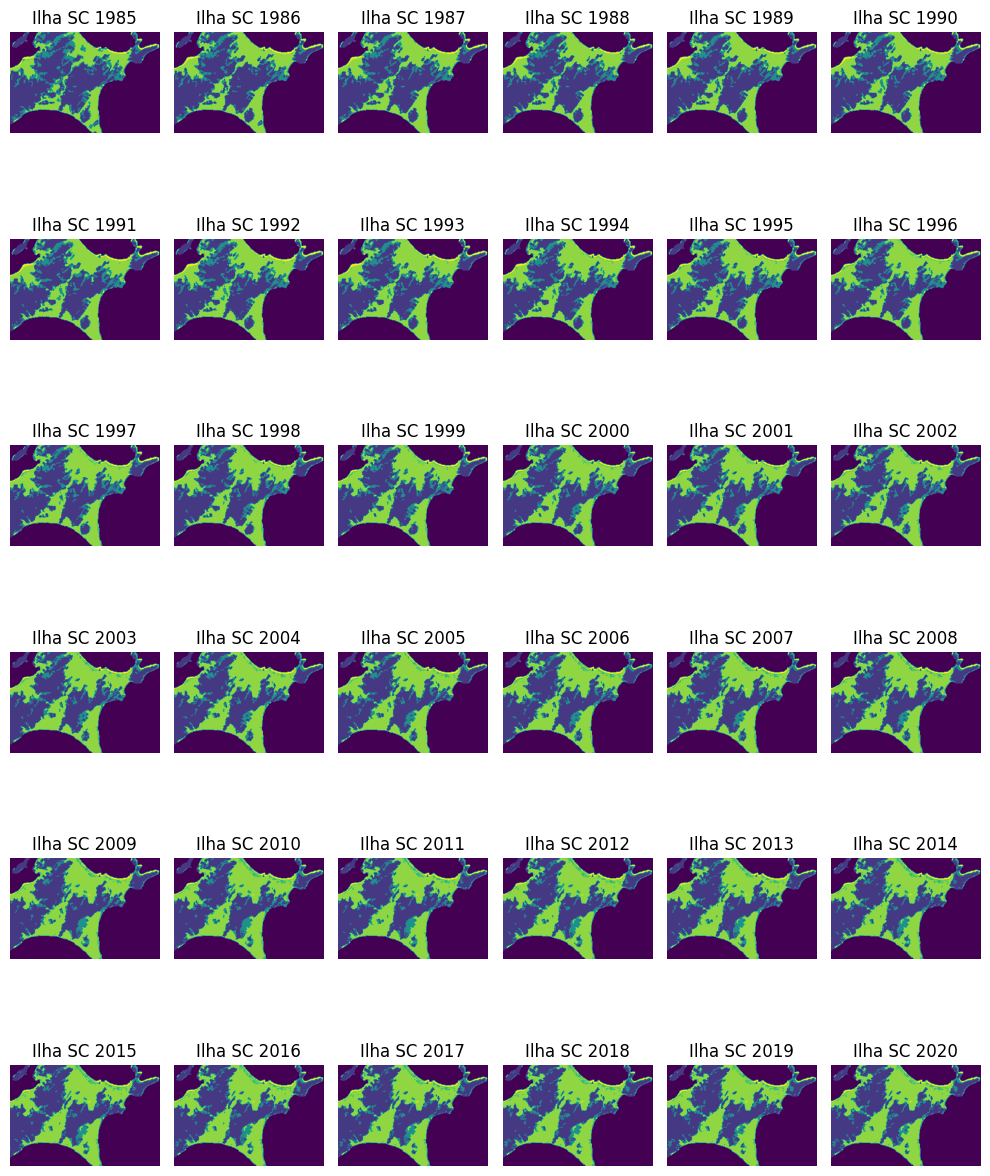

In [ ]:
fig, axs = plt.subplots(6, 6, figsize = (10,13))

for i, ax in enumerate(axs.flat):
  #if i >= 35: break
  ax.imshow(imagens[i])
  #print(imagens_bq[i].shape)
  ax.set_title("Ilha SC "+str(1985+i))
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
dataset = imagens

In [ ]:
dataset = np.expand_dims(dataset, axis=0)
print(dataset.shape)

(1, 36, 216, 319, 1)


In [ ]:
#dataset de teino e validacao serão os mesmos, mas shiftados em 1 posicao

train_dataset = dataset
val_dataset = dataset

def create_shifted_frames(data):
    x = data[ :, 0 : data.shape[1] - 1, :, :]
    y = data[ :, 1 : data.shape[1], :, :]
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

In [ ]:
from tensorflow.keras.layers import ConvLSTM2D, Conv3D, BatchNormalization, Input
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential()

model.add(Input(shape=(None, *x_train.shape[2:])))
model.add(ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu"))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu"))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=16, kernel_size=(1, 1), padding="same", return_sequences=True, activation="relu"))
model.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"))

In [ ]:
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, 216, 319, 3  105728    
                             2)                                  
                                                                 
 batch_normalization (BatchN  (None, None, 216, 319, 3  128      
 ormalization)               2)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 216, 319, 3  204928    
                             2)                                  
                                                                 
 batch_normalization_1 (Batc  (None, None, 216, 319, 3  128      
 hNormalization)             2)                                  
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, None, 216, 319, 1  3

In [ ]:
#Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

#Hiperparâmetros
epochs = 100
batch_size = 2

#Treinamento do modelo
model.fit(x_train, y_train, batch_size, epochs, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/100
1/1 [==============================] - 24s 24s/step - loss: 0.6216 - val_loss: 0.7820 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 0.5662 - val_loss: 0.5334 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 4s 4s/step - loss: 0.6076 - val_loss: -0.4060 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 0.5036 - val_loss: -4.4663 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 3s 3s/step - loss: 0.4382 - val_loss: -3.7585 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 4s 4s/step - loss: 0.3250 - val_loss: 0.1946 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 4s 4s/step - loss: 0.4306 - val_loss: 0.3060 - lr: 0.0010
Epoch 8/100
1/1 [==============================] - 4s 4s/step - loss: 0.4547 - val_loss: 0.5111 - lr: 0.0010
Epoch 9/100
1/1 [==============================] - 3s 3s/step - loss: 0.4053 - val_loss: 0.6286 - lr: 0.0010
Epoch 10/100
1

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[0]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

In [ ]:
print(frames.shape)

frames = np.expand_dims(frames, axis = 0)
original_frames = np.expand_dims(original_frames, axis = 0)
print(frames.shape)
print(original_frames.shape)

(10, 216, 319, 1)
(1, 10, 216, 319, 1)
(1, 26, 216, 319, 1)


1/1 [==============================] - 1s 1s/step
(1, 10, 216, 319, 1)
1/1 [==============================] - 1s 1s/step
(1, 11, 216, 319, 1)
1/1 [==============================] - 1s 911ms/step
(1, 12, 216, 319, 1)
1/1 [==============================] - 0s 334ms/step
(1, 13, 216, 319, 1)
1/1 [==============================] - 0s 441ms/step
(1, 14, 216, 319, 1)


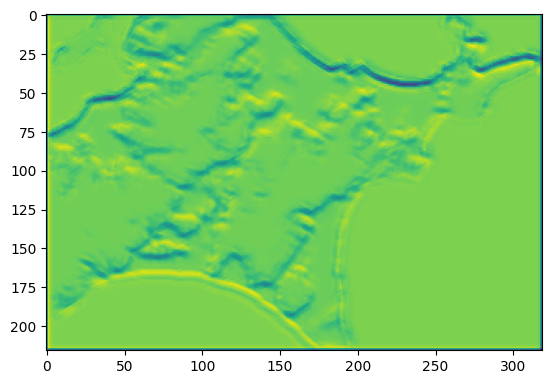

In [ ]:
for i in range(5):
  nova_predicao = model.predict(frames)
  print(nova_predicao.shape)
  predicted_frame  = nova_predicao[0][9]
  plt.imshow(predicted_frame)
  predicted_frame  = np.expand_dims(predicted_frame, axis= 0)   #para concatenar é necessário ter dimensões iguais
  predicted_frame  = np.expand_dims(predicted_frame, axis= 0)   #aplicando a transformação (x,y,c) --> (1, 1, x, y, c)
  frames = np.concatenate((frames, predicted_frame), axis = 1)